In [2]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cmplt
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

from PIL import Image, ImageDraw

from yt.config import ytcfg
import yt
from yt.analysis_modules.ppv_cube.api import PPVCube
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import skimage
from skimage import filters
from skimage.filters import window

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian
from scipy.ndimage import map_coordinates

# from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee

#I/O
import h5py
import pickle
import glob
import copy
import time
import os
#from bs4 import BeautifulSoup
import scipy.io as sio

#Plotting Style
%matplotlib inline
plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2
from multiprocessing import Pool

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)

/opt/miniconda3/envs/IWST/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]
<ipython-input-2-5af7b4fd052f>:28: VisibleDeprecationWarning: Development of the PPVCube module has been moved to the yt_astro_analysis package. This version is deprecated and will be removed from yt in a future release. See https://github.com/yt-project/yt_astro_analysis for further information.
  from yt.analysis_modules.ppv_cube.api import PPVCube


In [11]:
mnist_train_y = hd5_open('../scratch_AKS/mnist_train_y.h5','main/data')
mnist_test_y = hd5_open('../scratch_AKS/mnist_test_y.h5','main/data')

In [9]:
mnist_DHC_out = hd5_open('../scratch_AKS/mnist_DHC_out.h5','main/data')
mnist_DHC_out_test = hd5_open('../scratch_AKS/mnist_DHC_out_test.h5','main/data')

In [10]:
mnist_DHC_out.shape,mnist_DHC_out_test.shape

((60000, 1124), (10000, 1124))

In [14]:
mnist_train_y

array([5, 0, 4, ..., 5, 6, 8])

In [24]:
def LDA_AKS_testman(X_train,y_train,X_test,y_test,n_components,label_list):
    lda = LDA(n_components=n_components)
    X_train = lda.fit_transform(X_train, y_train)
    y_pred = lda.predict(X_test)
    X_test = lda.transform(X_test)
    cm = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred,average='micro')
    print('Accuracy' + str(prec))
    cmap_normal = (cm.T/cm.sum(axis=1)).T
    
    ## Good plots
    vmin=y_train.min()
    vmax=y_train.max()
    marker_size = 10

    from matplotlib import cm as cmplt
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    rgba_colors = [cmplt.hsv(norm(i)) for i in label_list]
    color_order = ["black", "white"]
    color_map = "gray"
    colormap='hsv'
    
    fig = plt.figure(figsize=(12,12),dpi=150)

    ax = fig.add_subplot(2,2,1)    
    ax.imshow(cmap_normal,
          interpolation='nearest',
          cmap=color_map,
          aspect='equal',
          vmin=0,vmax=1)

    ax.set_xticks(np.arange(cm.shape[0]))
    ax.set_yticks(np.arange(cm.shape[1]))
    
    for ytick, color in zip(ax.get_yticklabels(), rgba_colors):
        ytick.set_color(color)

    ax.set_xticklabels(label_list)
    ax.set_yticklabels(label_list)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",va='center',
             rotation_mode="anchor")
    plt.title('Test-Train Fidelity ({:.2f}%)'.format(100*prec))

    # Loop over data dimensions and create text annotations.
    textcolors=color_order
    threshold = 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] != 0:
                text = ax.text(j, i, cm[i, j],
                               ha="center", va="center", 
                               color=textcolors[int(cmap_normal[i, j] < threshold)])
    if n_components == 1:
        ax = fig.add_subplot(2,2,2)
        #ax.scatter(X_train, y_train, s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
        #ax.scatter(X_test, y_test, s=2, marker='^', zorder=10,c=y_test, cmap = 'bwr',alpha=0.5)
        sns.distplot(X_test[y_test==0],ax=ax)
        sns.distplot(X_test[y_test==1],ax=ax)
        plt.xlabel('$LDA_{}$'.format(0))
        plt.ylabel('Probability Density')
        plt.title('LDA Projection')
        
    if n_components == 2:
        ax = fig.add_subplot(2,2,2)
        #ax.scatter(X_train[:,0], X_train[:,1], s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
        ax.scatter(X_test[:,0], X_test[:,1], s=2, marker='^', zorder=10,c=y_test, cmap = colormap, vmin=vmin, vmax=vmax,alpha=0.5)
        plt.xlabel('$LDA_{}$'.format(i-2))
        plt.ylabel('$LDA_{}$'.format(i-1))
        plt.title('LDA Projection')
    elif n_components > 2:
        for i in range(2,5):
            ax = fig.add_subplot(2,2,i)
            #ax.scatter(X_train[:,i-2], X_train[:,i-1], s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
            ax.scatter(X_test[:,i-2], X_test[:,i-1], s=2, marker='^', zorder=10,c=y_test, cmap = colormap, vmin=vmin, vmax=vmax,alpha=0.5)
            plt.xlabel('$LDA_{}$'.format(i-2))
            plt.ylabel('$LDA_{}$'.format(i-1))
            plt.title('LDA Projection')

    fig.subplots_adjust(wspace=0.6, hspace=0.6)
    plt.show()
    
    return (lda,cm,X_train,X_test,y_train,y_test,y_pred)

Accuracy0.9515


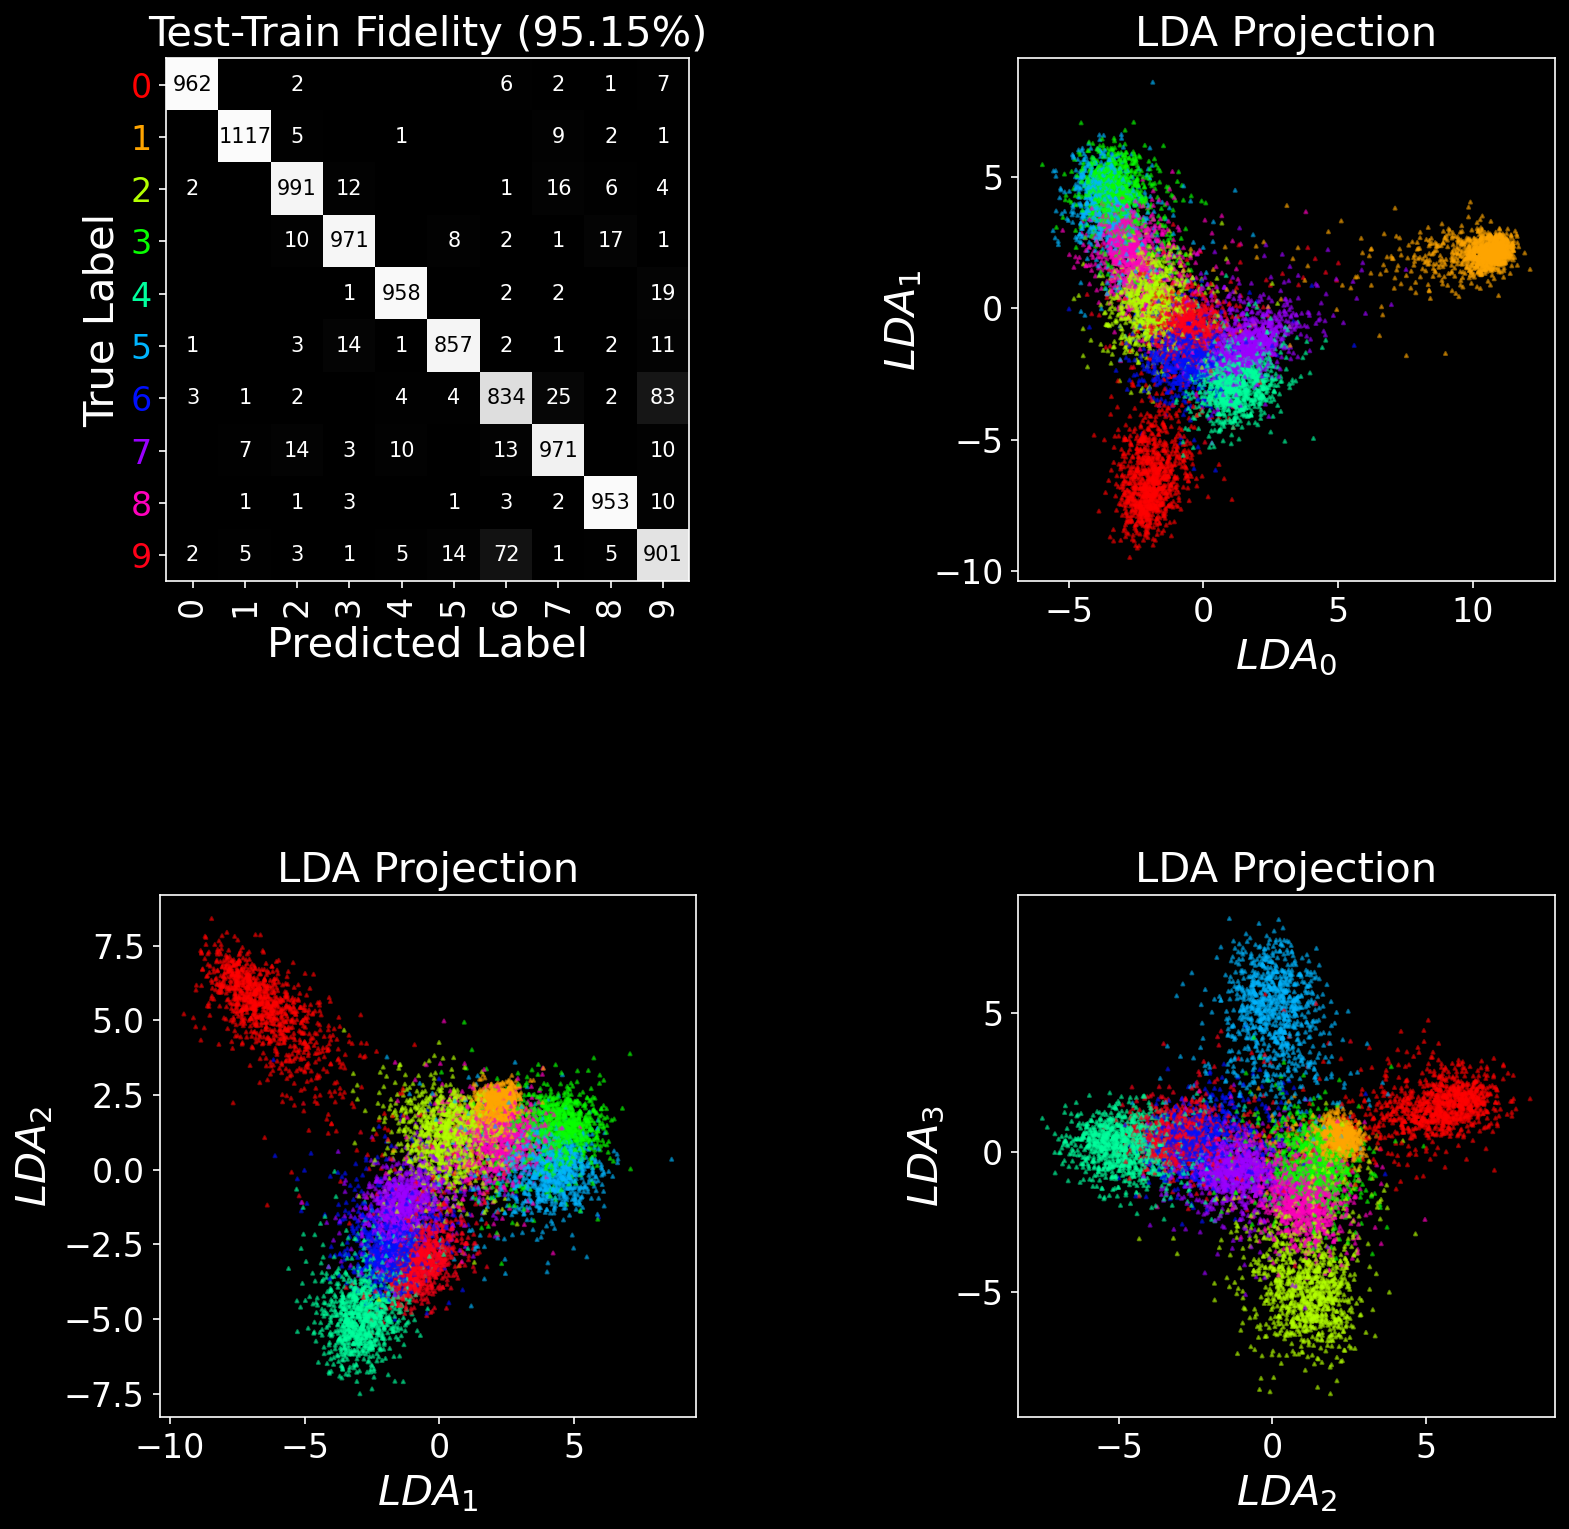

In [25]:
N = 10
labels = [0,1,2,3,4,5,6,7,8,9]
out = LDA_AKS_testman(mnist_DHC_out,mnist_train_y,mnist_DHC_out_test,mnist_test_y,N-1,labels)

In [28]:
mnist_DHC_out_rot7pi = hd5_open('../scratch_AKS/mnist_DHC_out_rot7pi_8.h5','main/data')
mnist_DHC_out_rot7pi_test = hd5_open('../scratch_AKS/mnist_DHC_out_rot7pi_8_test.h5','main/data')

Accuracy0.9519


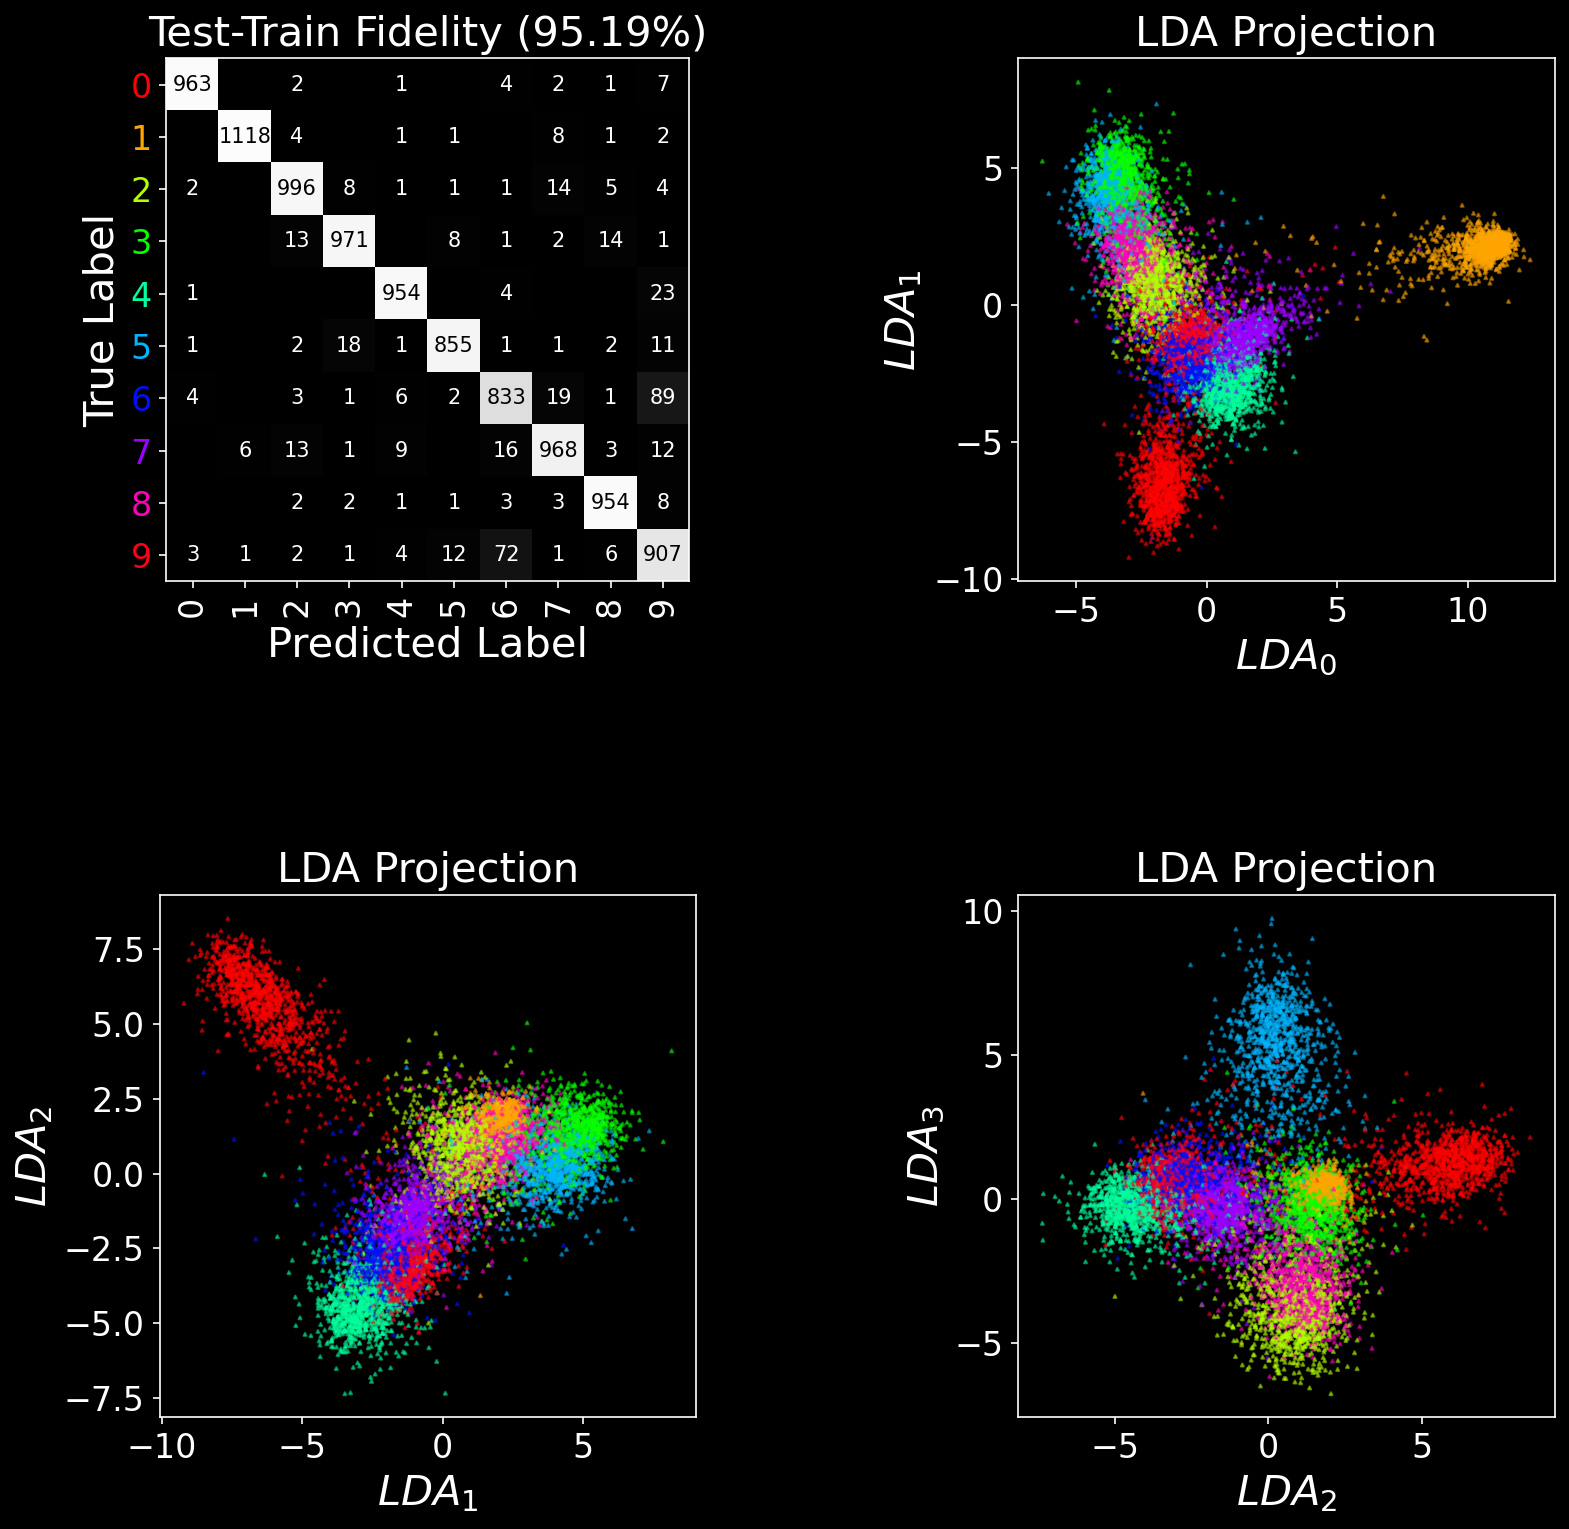

In [29]:
N = 10
labels = [0,1,2,3,4,5,6,7,8,9]
out = LDA_AKS_testman(mnist_DHC_out_rot7pi,mnist_train_y,mnist_DHC_out_rot7pi_test,mnist_test_y,N-1,labels)

Accuracy0.7571


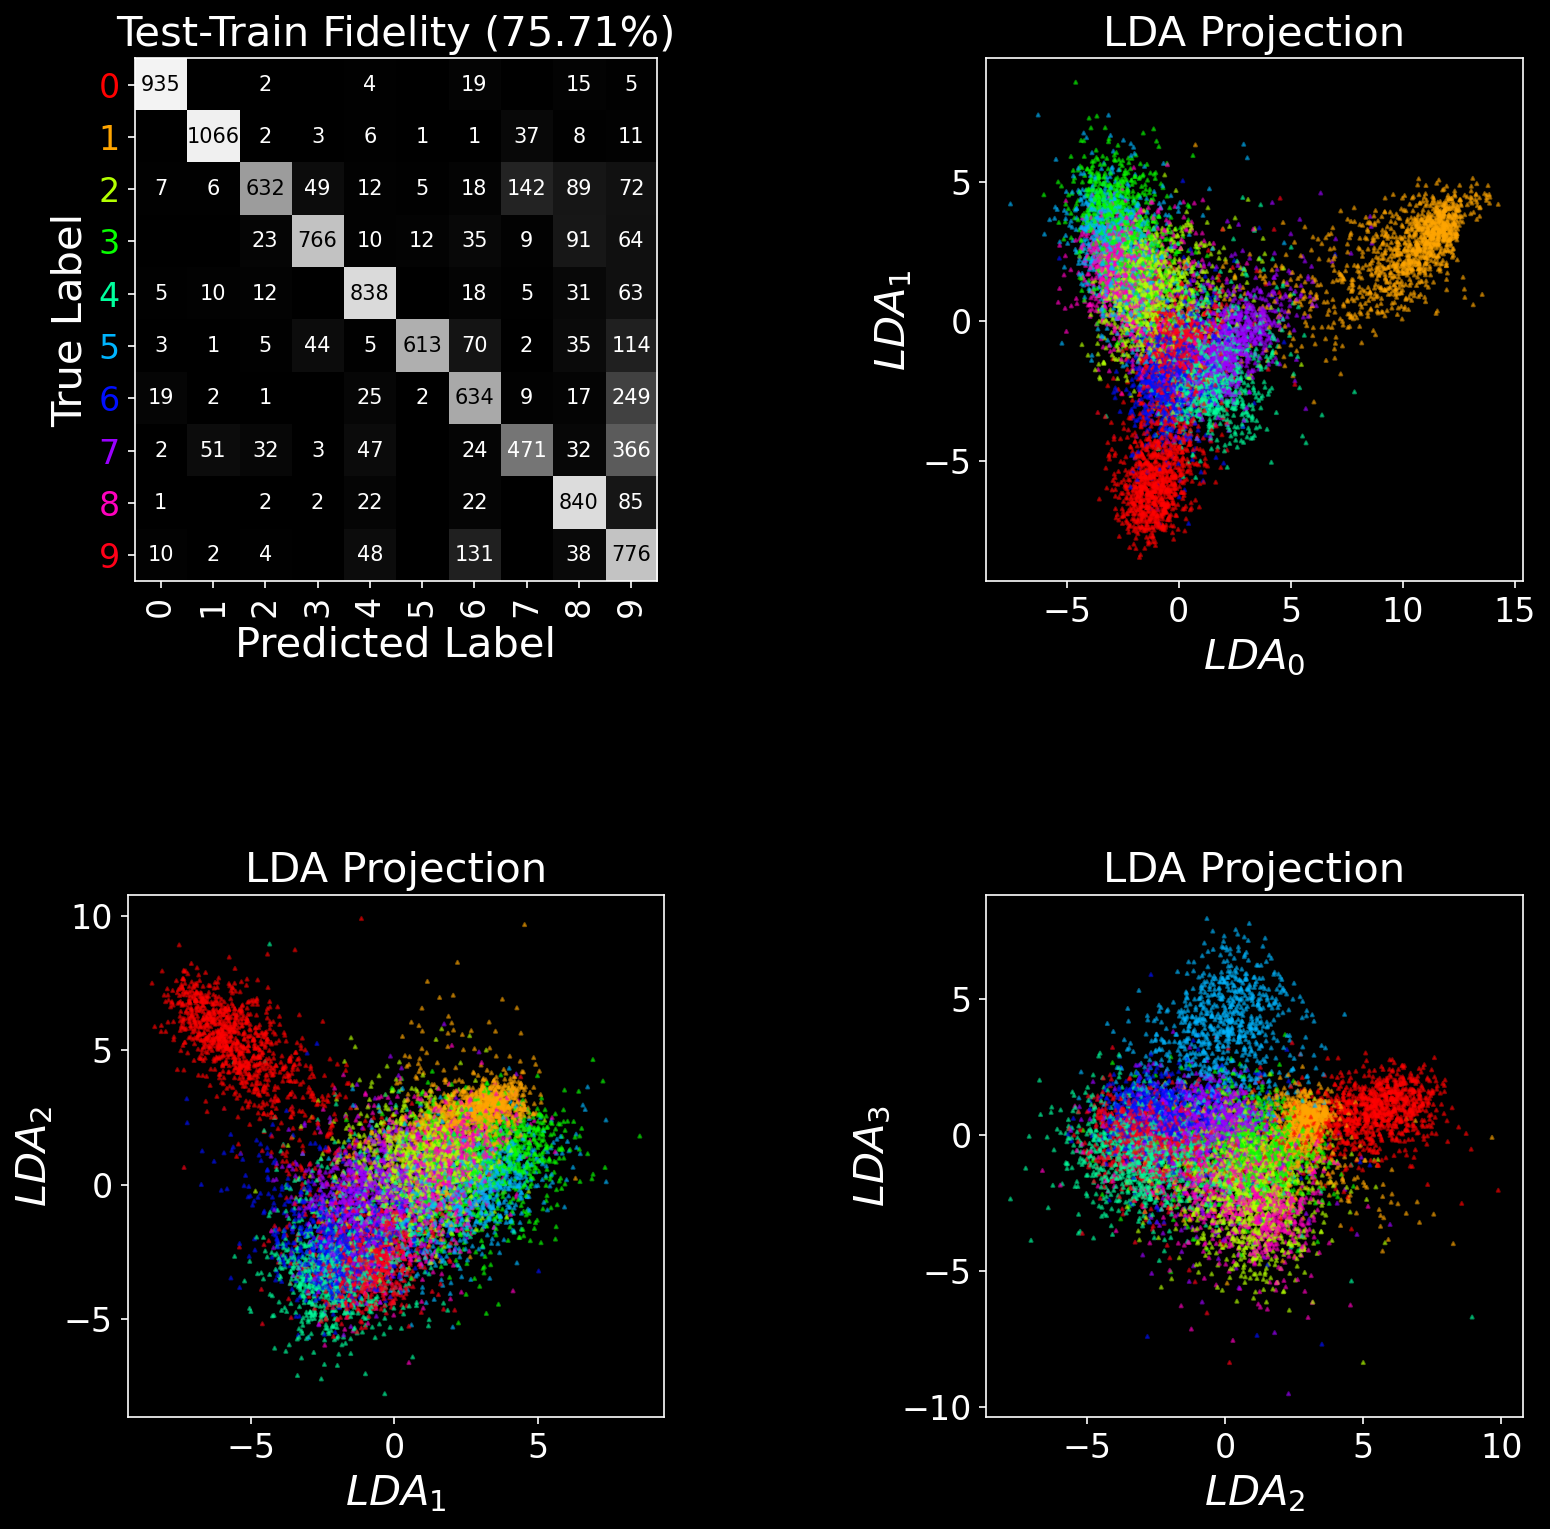

In [30]:
N = 10
labels = [0,1,2,3,4,5,6,7,8,9]
out = LDA_AKS_testman(mnist_DHC_out_rot7pi,mnist_train_y,mnist_DHC_out_test,mnist_test_y,N-1,labels)

Accuracy0.7757


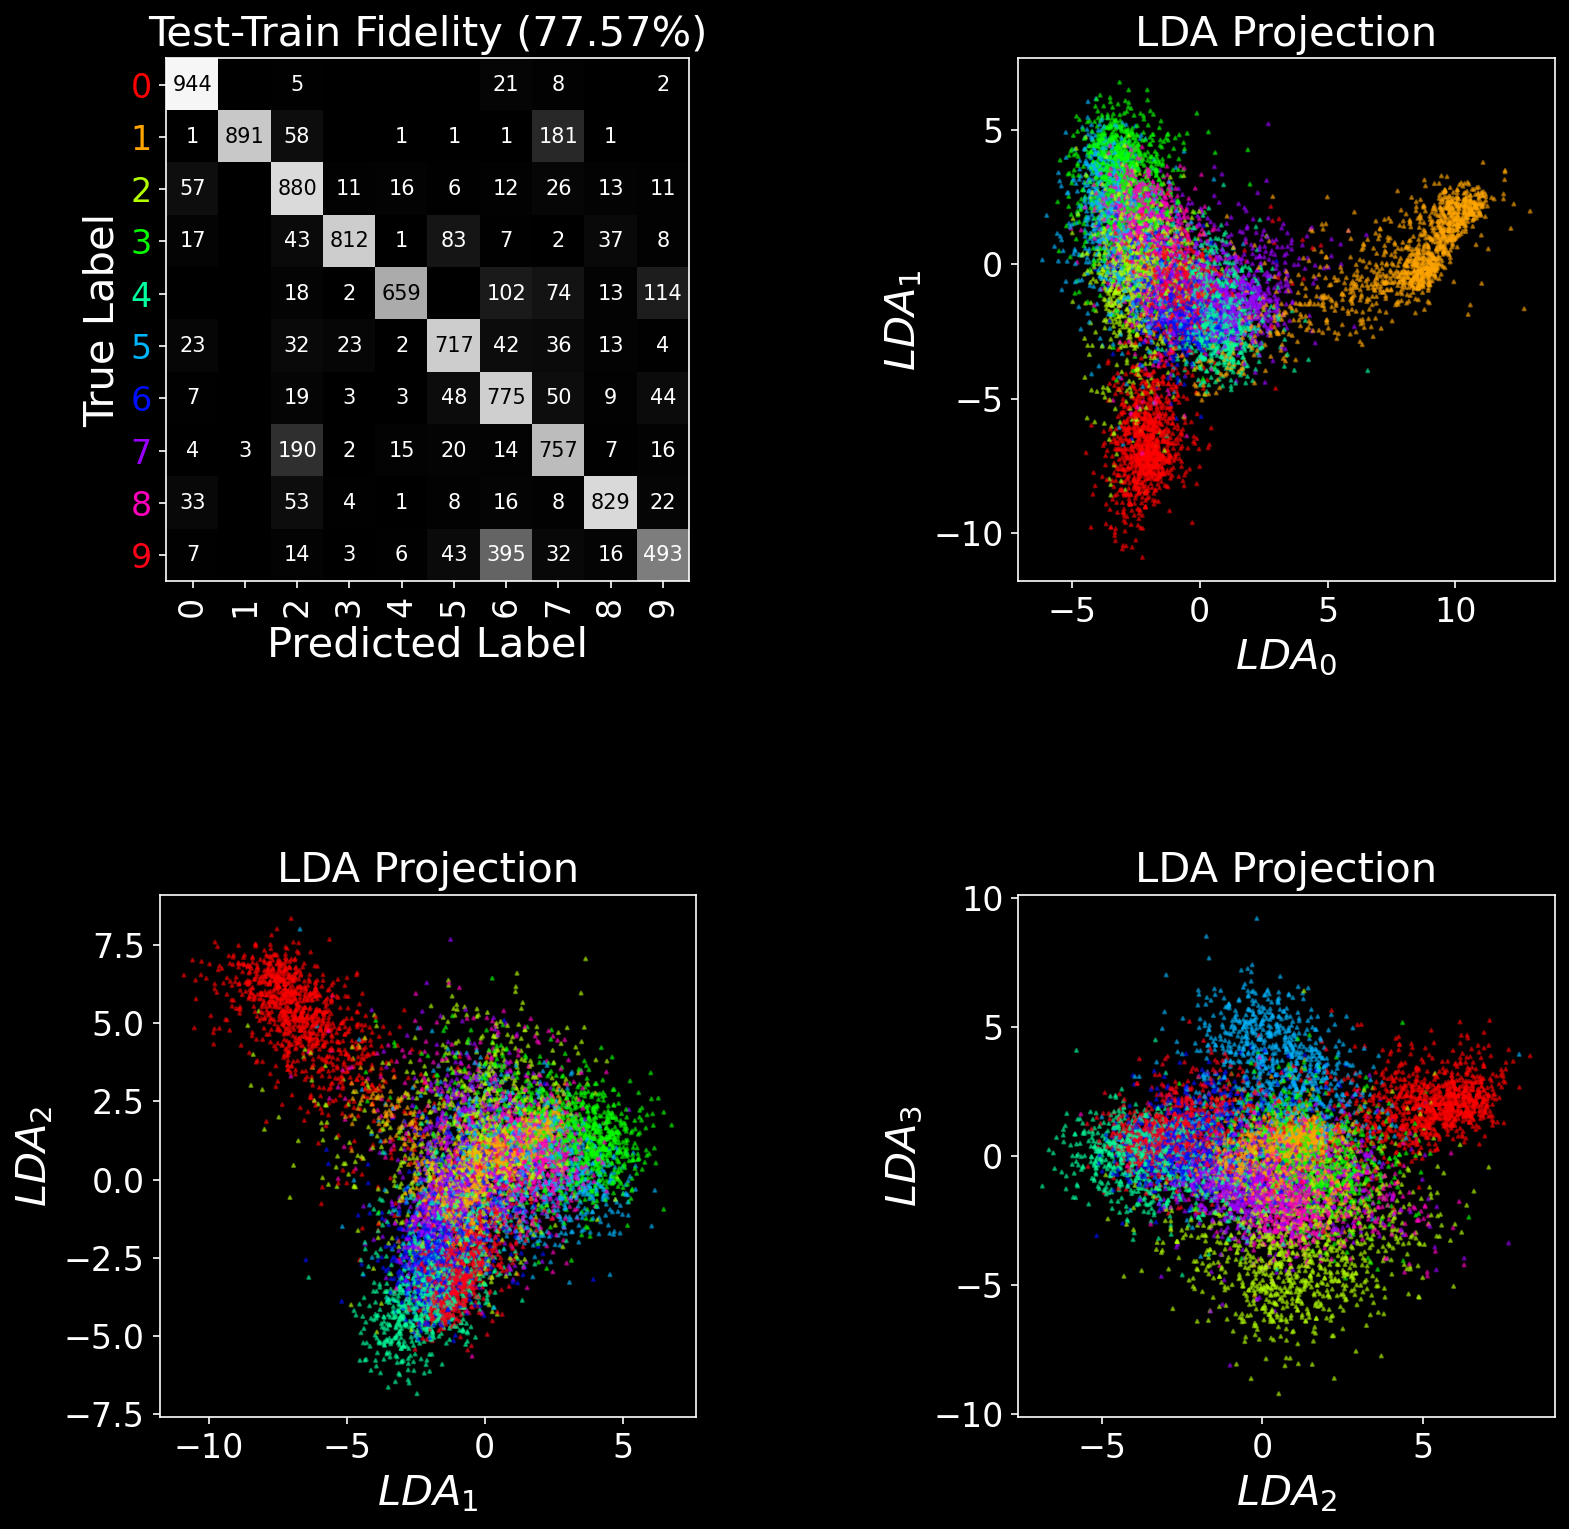

In [31]:
N = 10
labels = [0,1,2,3,4,5,6,7,8,9]
out = LDA_AKS_testman(mnist_DHC_out,mnist_train_y,mnist_DHC_out_rot7pi_test,mnist_test_y,N-1,labels)

In [32]:
mnist_DHC_out_rotpi_3 = hd5_open('../scratch_AKS/mnist_DHC_out_rotpi_3.h5','main/data')
mnist_DHC_out_rotpi_3_test = hd5_open('../scratch_AKS/mnist_DHC_out_rotpi_3_test.h5','main/data')

mnist_DHC_out_rot2pi_3 = hd5_open('../scratch_AKS/mnist_DHC_out_rot2pi_3.h5','main/data')
mnist_DHC_out_rot2pi_3_test = hd5_open('../scratch_AKS/mnist_DHC_out_rot2pi_3_test.h5','main/data')

mnist_DHC_out_rot3pi_3 = hd5_open('../scratch_AKS/mnist_DHC_out_rot3pi_3.h5','main/data')
mnist_DHC_out_rot3pi_3_test = hd5_open('../scratch_AKS/mnist_DHC_out_rot3pi_3_test.h5','main/data')

mnist_DHC_out_rot4pi_3 = hd5_open('../scratch_AKS/mnist_DHC_out_rot4pi_3.h5','main/data')
mnist_DHC_out_rot4pi_3_test = hd5_open('../scratch_AKS/mnist_DHC_out_rot4pi_3_test.h5','main/data')

mnist_DHC_out_rot5pi_3 = hd5_open('../scratch_AKS/mnist_DHC_out_rot5pi_3.h5','main/data')
mnist_DHC_out_rot5pi_3_test = hd5_open('../scratch_AKS/mnist_DHC_out_rot5pi_3_test.h5','main/data')

In [37]:
mnist_DHC_out_stack = np.vstack((mnist_DHC_out, mnist_DHC_out_rotpi_3,mnist_DHC_out_rot2pi_3,mnist_DHC_out_rot3pi_3,mnist_DHC_out_rot4pi_3,mnist_DHC_out_rot5pi_3))
mnist_DHC_out_stack_test = np.vstack((mnist_DHC_out_test, mnist_DHC_out_rotpi_3_test,mnist_DHC_out_rot2pi_3_test,mnist_DHC_out_rot3pi_3_test,mnist_DHC_out_rot4pi_3_test,mnist_DHC_out_rot5pi_3_test))

In [41]:
mnist_DHC_out_stack_train_y = np.hstack((mnist_train_y,mnist_train_y,mnist_train_y,mnist_train_y,mnist_train_y,mnist_train_y))
mnist_DHC_out_stack_test_y = np.hstack((mnist_test_y,mnist_test_y,mnist_test_y,mnist_test_y,mnist_test_y,mnist_test_y))

Accuracy0.913


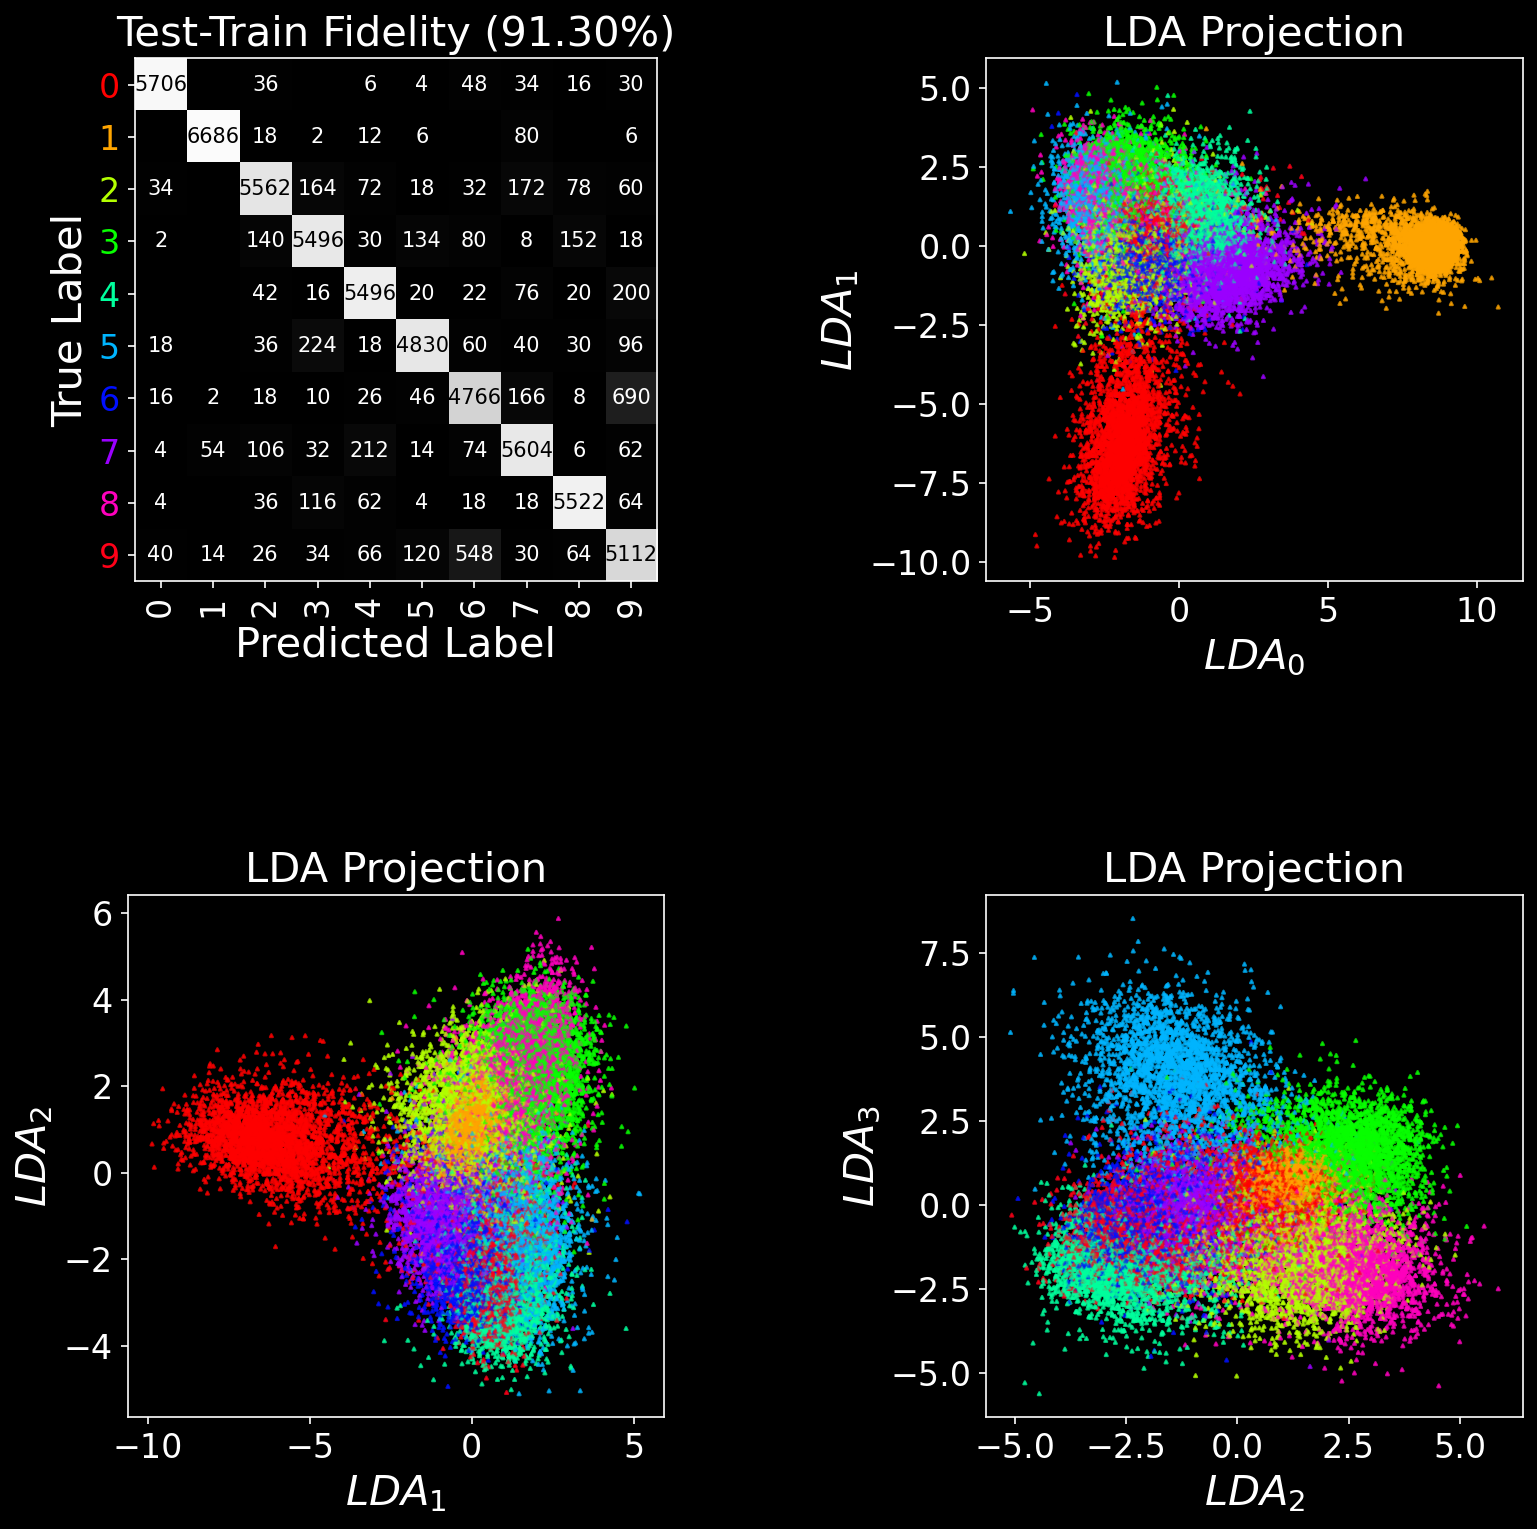

In [44]:
N = 10
labels = [0,1,2,3,4,5,6,7,8,9]
out = LDA_AKS_testman(mnist_DHC_out_stack,mnist_DHC_out_stack_train_y,mnist_DHC_out_stack_test,mnist_DHC_out_stack_test_y,N-1,labels)

Accuracy0.46753333333333336


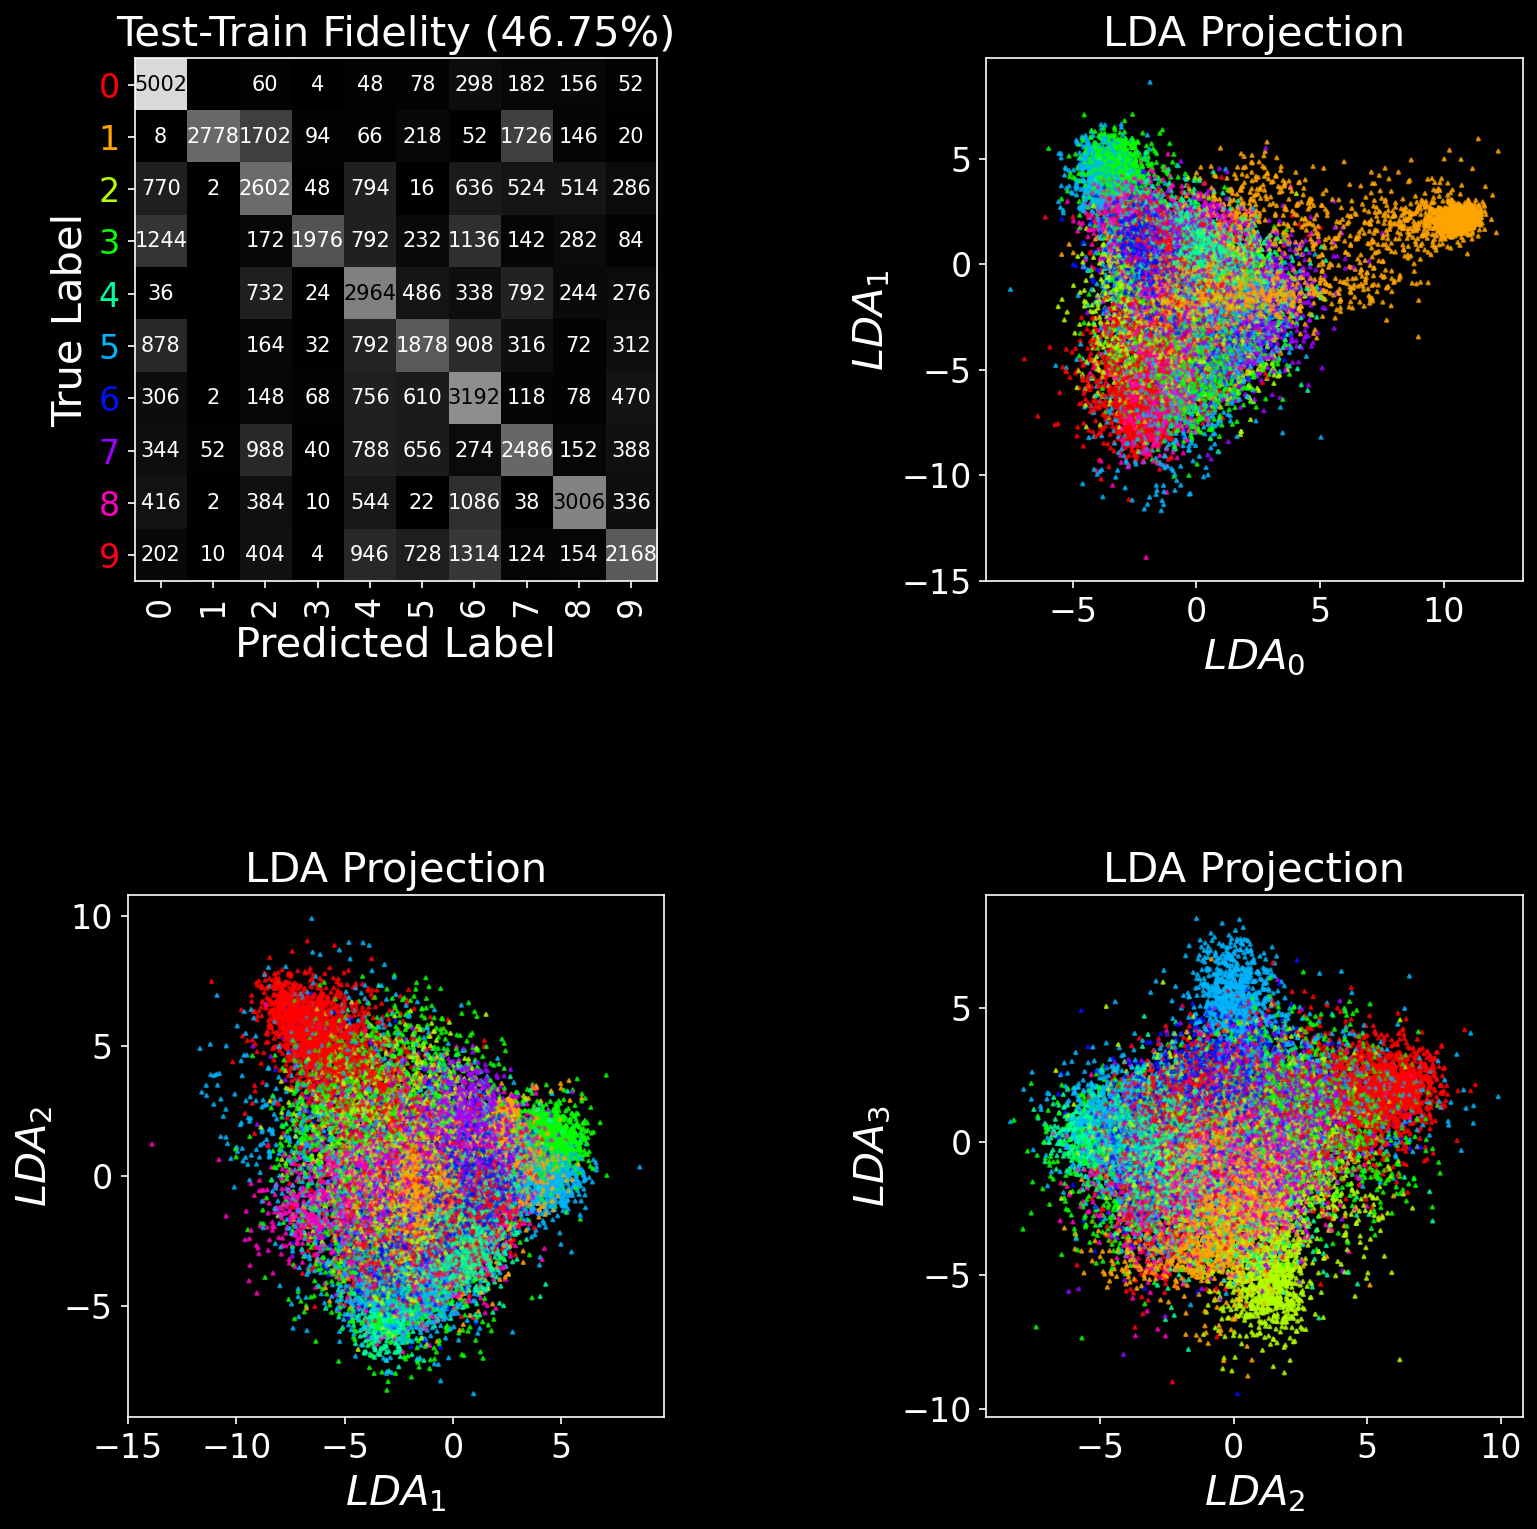

In [45]:
N = 10
labels = [0,1,2,3,4,5,6,7,8,9]
out = LDA_AKS_testman(mnist_DHC_out,mnist_train_y,mnist_DHC_out_stack_test,mnist_DHC_out_stack_test_y,N-1,labels)

Accuracy0.4843


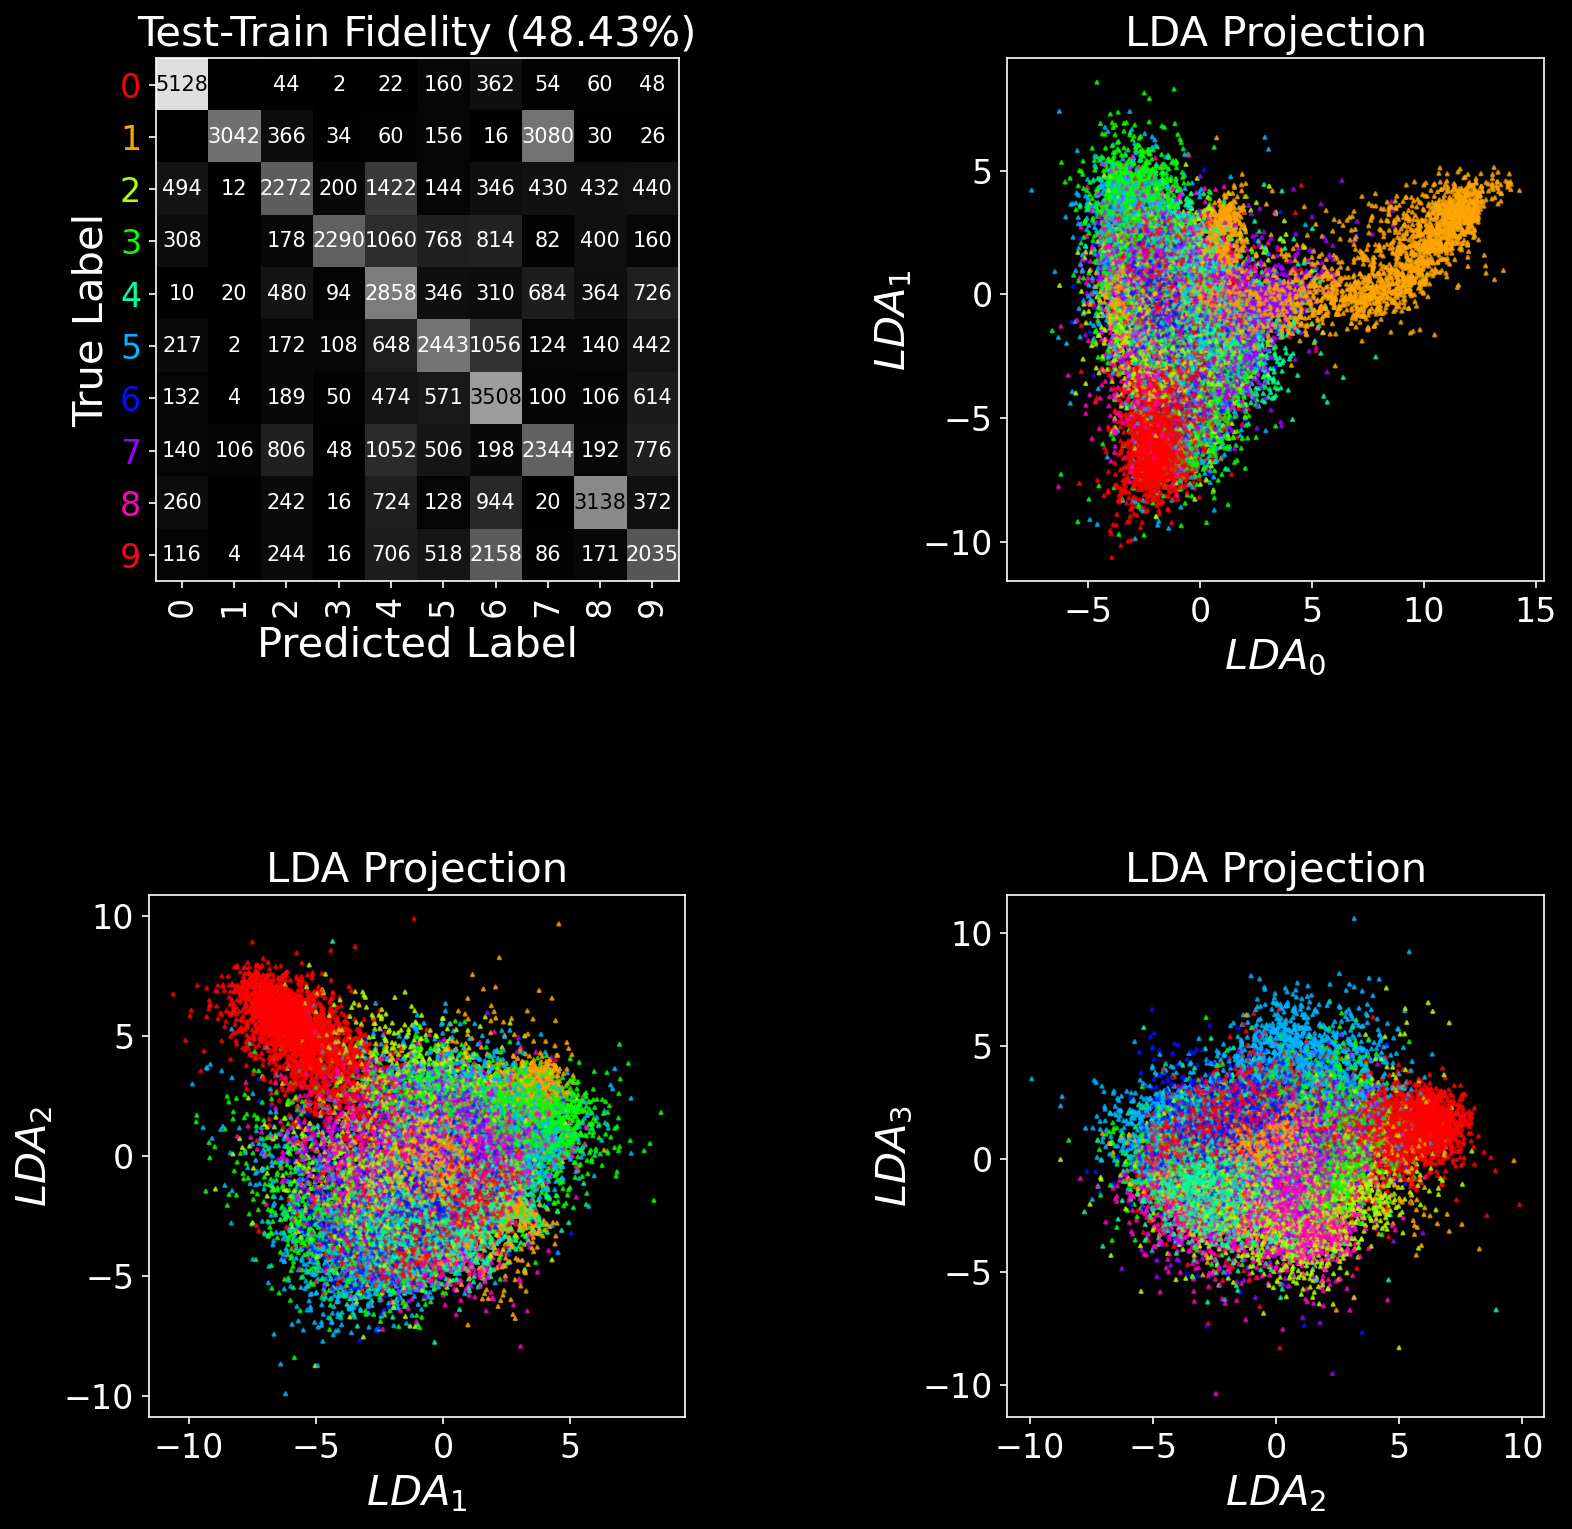

In [46]:
N = 10
labels = [0,1,2,3,4,5,6,7,8,9]
out = LDA_AKS_testman(mnist_DHC_out_rot7pi,mnist_train_y,mnist_DHC_out_stack_test,mnist_DHC_out_stack_test_y,N-1,labels)

Accuracy0.9145


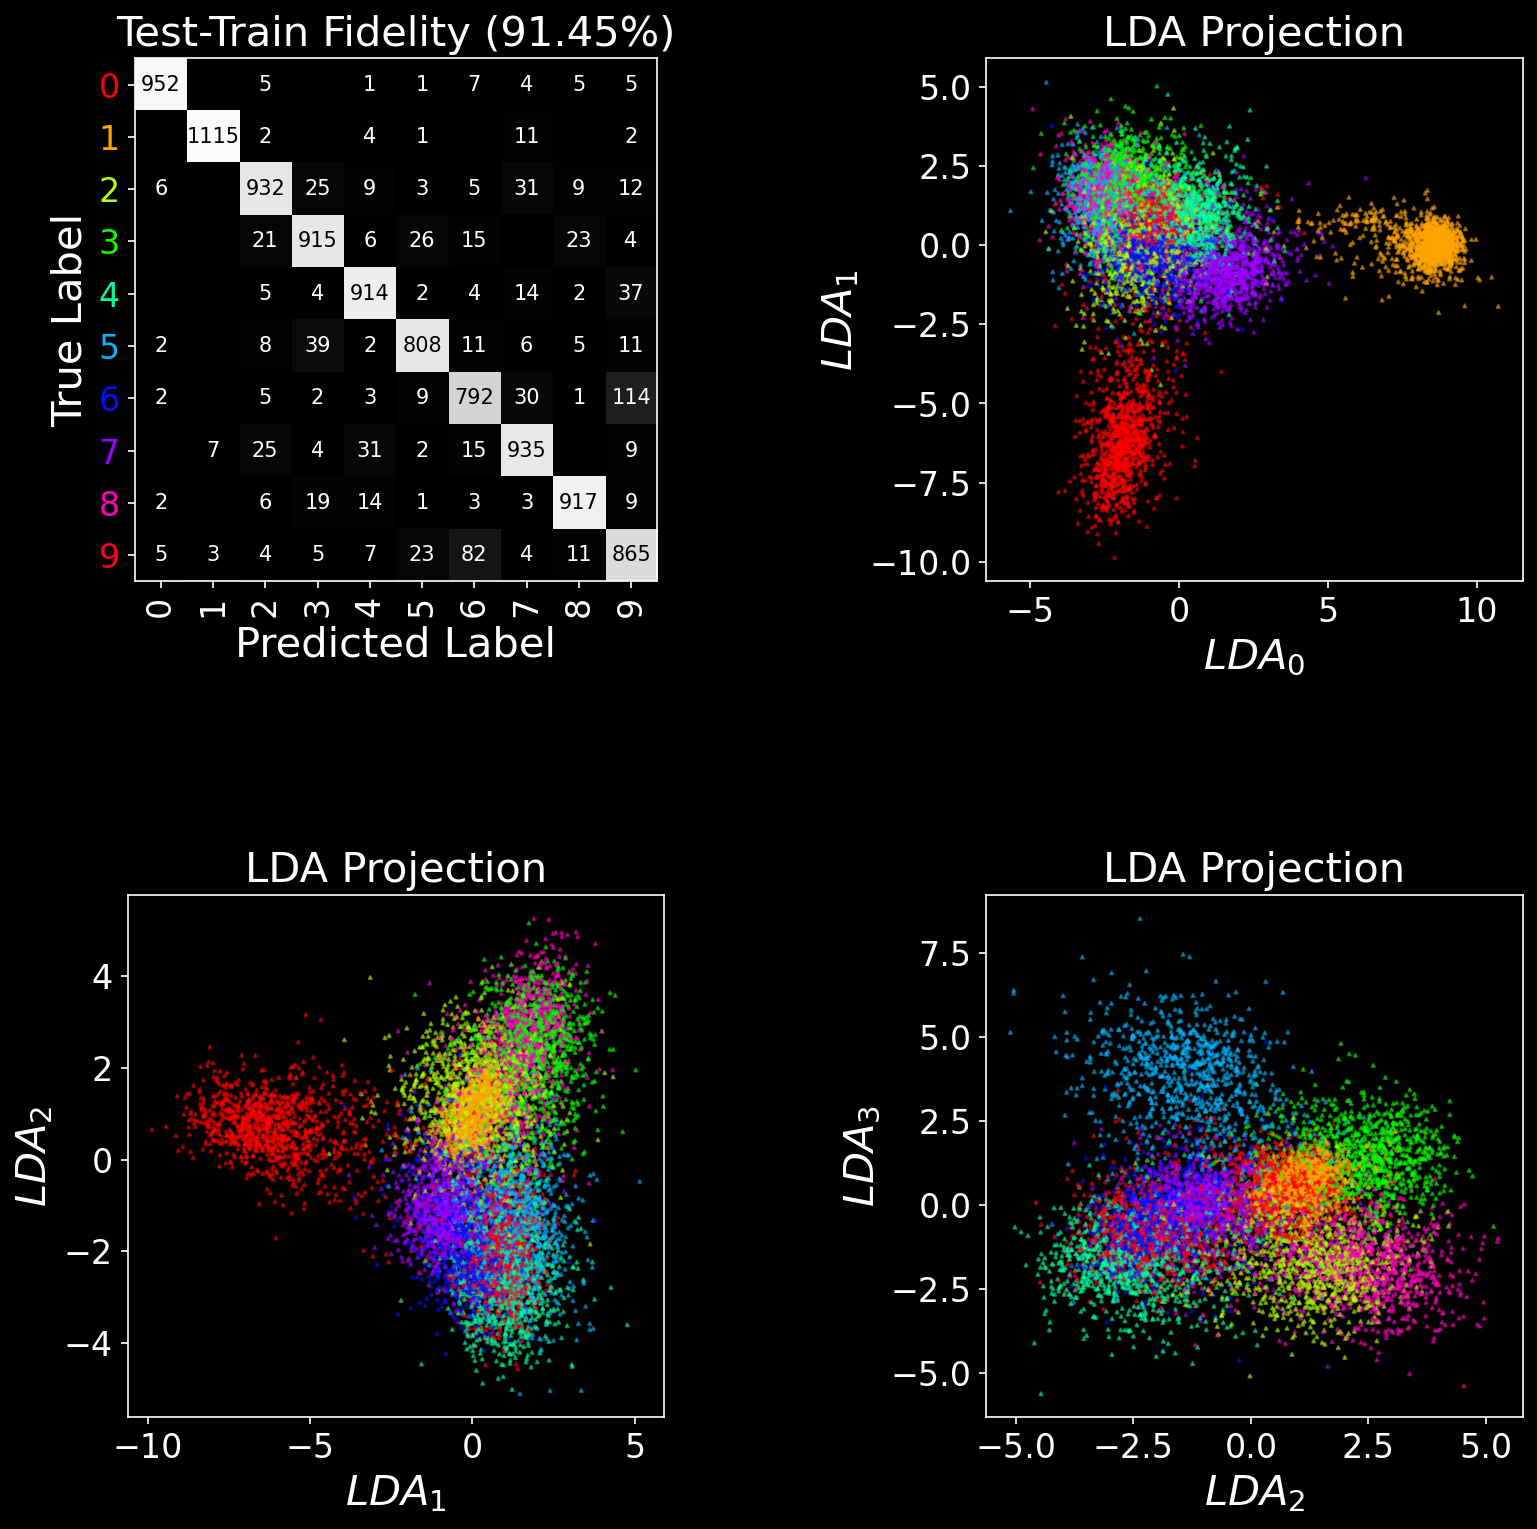

In [47]:
N = 10
labels = [0,1,2,3,4,5,6,7,8,9]
out = LDA_AKS_testman(mnist_DHC_out_stack,mnist_DHC_out_stack_train_y,mnist_DHC_out_test,mnist_test_y,N-1,labels)

Accuracy0.7775


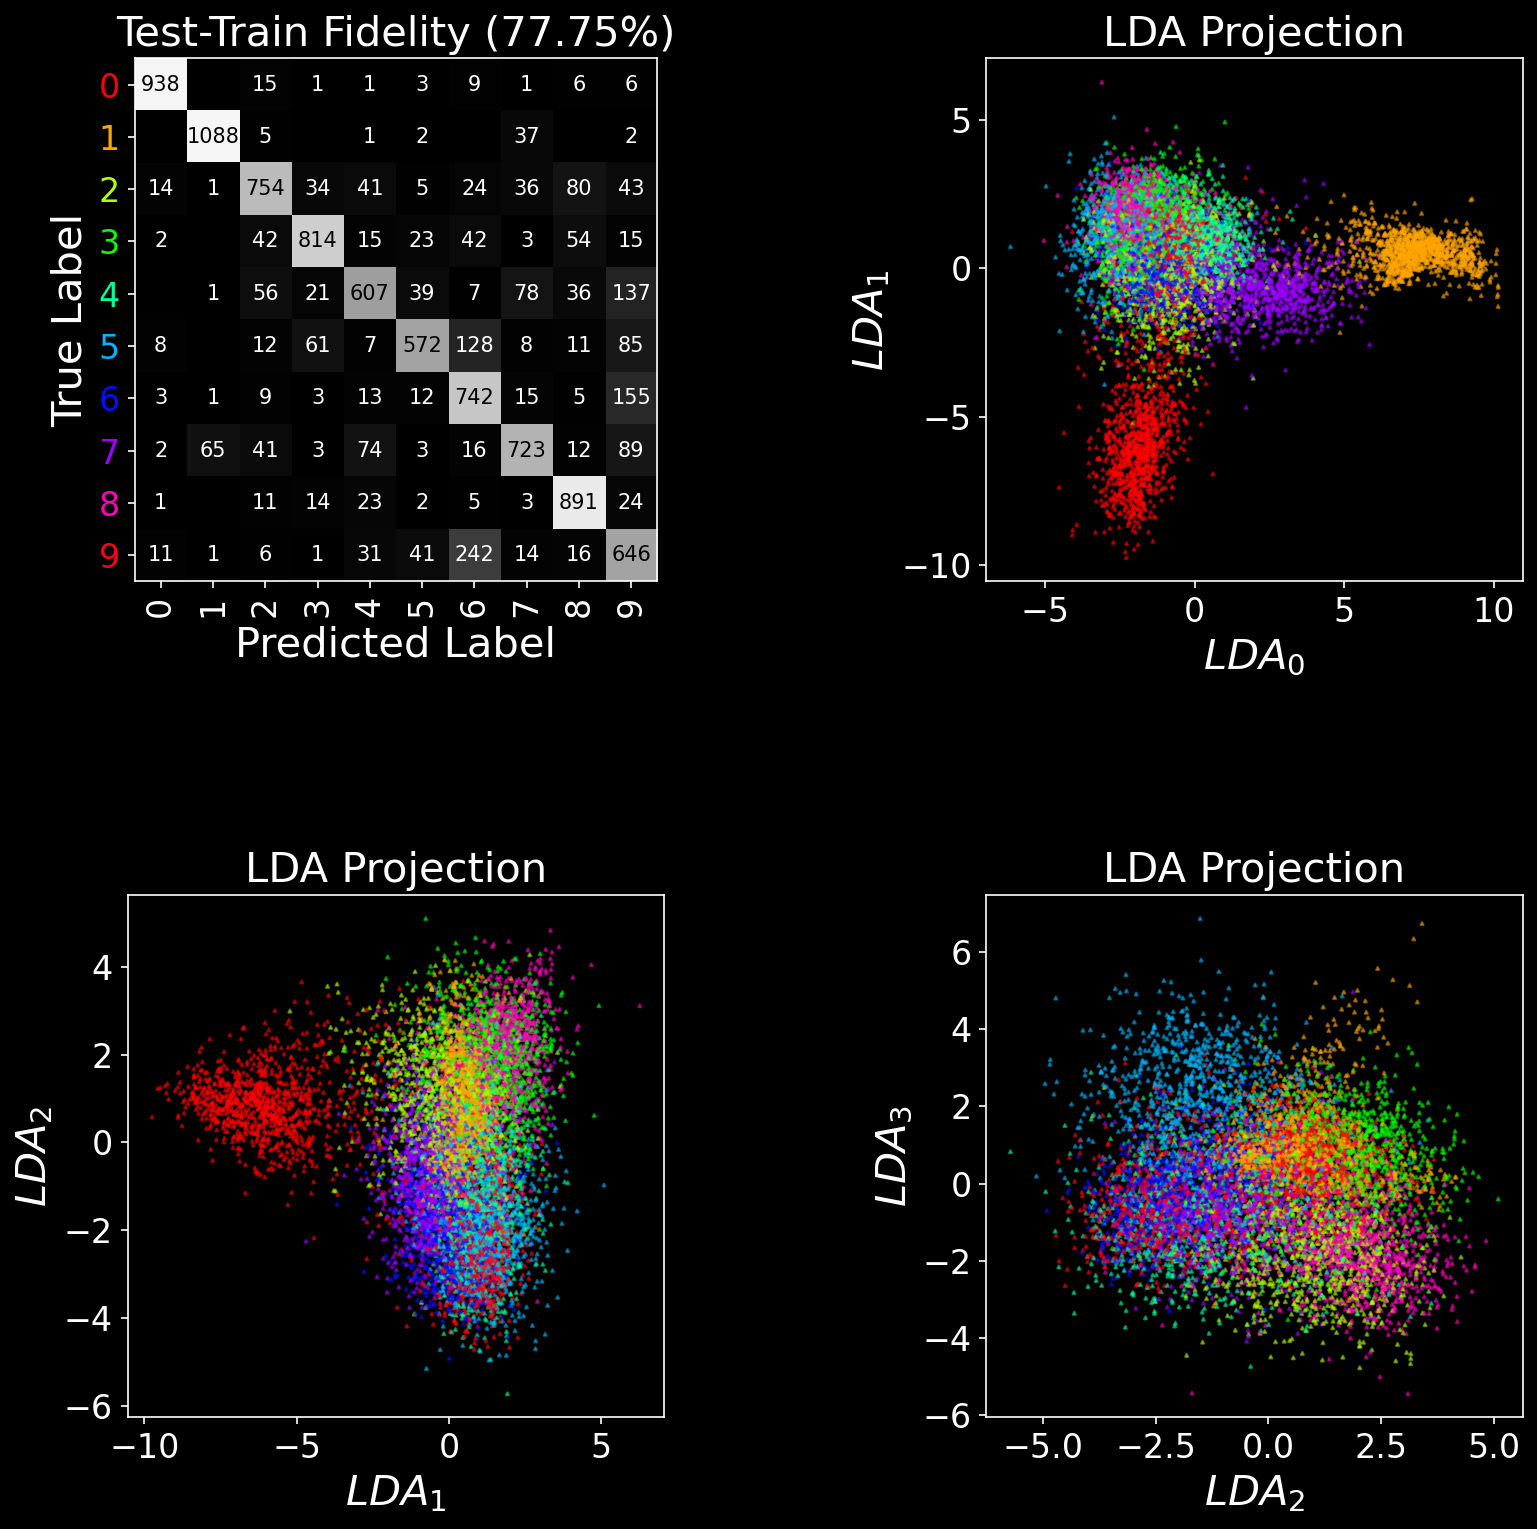

In [48]:
N = 10
labels = [0,1,2,3,4,5,6,7,8,9]
out = LDA_AKS_testman(mnist_DHC_out_stack,mnist_DHC_out_stack_train_y,mnist_DHC_out_rot7pi_test,mnist_test_y,N-1,labels)